In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.15.2%2Bcu117-cp310-cp310-win_amd64.whl (4.9 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-2.0.2%2Bcu117-cp310-cp310-win_amd64.whl (2.5 MB)
     -------------------------------------- 62.8/62.8 kB 674.4 kB/s eta 0:00:00
     ---------------------------------------- 2.3/2.3 GB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 61.5/61.5 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 140.6/140.6 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.7.1
    Uninstalling torch-2.7.1:
      Successfully uninstalled torch-2.7.1
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\griff\\anaconda3\\envs\\vision\\Lib\\site-packages\\~orch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [ ]:
%pip install numpy<2

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
# from CNN_LSTM import VisualCNN

class BallPredictorCNN(nn.Module):
    def __init__(self, n_raycasts=107):
        """
        Args:
            n_raycasts (int): The number of raycasts in the input vector (n).
        """
        super(BallPredictorCNN, self).__init__()
        
        # We define the convolutional part of the network
        self.convolutional_layers = nn.Sequential(
            # Input shape: (batch_size, 1, n_raycasts)
            # The '1' is the number of input channels.
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            # Shape: (batch_size, 16, n_raycasts)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # Shape: (batch_size, 16, n_raycasts / 2)

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            # Shape: (batch_size, 32, n_raycasts / 2)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
            # Shape: (batch_size, 32, n_raycasts / 4)
        )
        
        # Calculate the size of the flattened layer after the convolutions
        # This is a robust way to do it without manual calculation
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, n_raycasts)
            flattened_size = self.convolutional_layers(dummy_input).flatten(1).shape[1]

        # We define the fully connected (regression) part of the network
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=flattened_size, out_features=64),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout for regularization
            nn.Linear(in_features=64, out_features=2) # Output layer for (x, z)
        )

    def forward(self, x):
        """
        The forward pass of the model.
        Args:
            x (torch.Tensor): The input tensor of raycasts. 
                              Expected shape: (batch_size, n_raycasts)
        """
        # Add a channel dimension for the Conv1d layers. Shape becomes (batch_size, 1, n_raycasts)
        x = x.unsqueeze(1)
        
        # Pass through convolutional layers
        x = self.convolutional_layers(x)
        
        # Flatten the output for the linear layers. Shape becomes (batch_size, flattened_size)
        x = x.flatten(1)
        
        # Pass through linear layers to get the final prediction
        prediction = self.linear_layers(x)
        
        return prediction

# --- Example Usage ---
# n_rays = 180
# model = BallPredictorCNN(n_raycasts=n_rays)
# 
# # Create a dummy batch of 32 samples
# dummy_raycasts = torch.randn(32, n_rays) 
# 
# # Get the predicted positions
# predicted_positions = model(dummy_raycasts)
# 
# print(f"Model Architecture:\n{model}")
# print(f"\nInput shape: {dummy_raycasts.shape}")
# print(f"Output shape: {predicted_positions.shape}") # Should be (32, 2)

In [3]:
X_rays = np.load('../data/CNN_LSTM/big_rays.npy')  # (N, T, R)
Y_pos =  np.load('../data/CNN_LSTM/big_pos.npy')    # (N, T, 2)
Y_vel =  np.load('../data/CNN_LSTM/big_vel.npy')    # (N, 2)
print("X_rays shape:", X_rays.shape)
print("Y_pos shape:", Y_pos.shape)
print("Y_vel shape:", Y_vel.shape)

Y_pos_final = Y_pos[:, -1, :]  # position at last time step

X_rays shape: (623757, 5, 107)
Y_pos shape: (623757, 5, 2)
Y_vel shape: (623757, 2)


In [5]:
# === Flatten dataset for frame-level training ===
# X_flat = X_rays.reshape(-1, X_rays.shape[2])           # (N*T, R)
# Y_flat = Y_pos.reshape(-1, Y_pos.shape[2]) # (N*T, 2)

X_tensor = torch.tensor(X_rays[:, -1, :], dtype=torch.float32)   # (N*T, R)
Y_tensor = torch.tensor(Y_pos_final, dtype=torch.float32)   # (N*T, 2)

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
# loader = DataLoader(TensorDataset(torch.tensor(X_rays_test[:, -1, :], dtype=torch.float32), torch.tensor(Y_pos_test[:, -1,:], dtype=torch.float32)), batch_size=2, shuffle=True)

# === Build model ===
# model = VisualCNN(num_rays=X_rays.shape[2])
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BallPredictorCNN(n_raycasts=X_rays.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Train loop ===
losses = []
for epoch in range(25):
    epoch_loss = 0
    for xb, yb in loader:
        pred = model(xb)               # xb: (B, R)
        loss = criterion(pred, yb)     # yb: (B, 2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")

Epoch 0: Loss = 0.0767
Epoch 1: Loss = 0.0695
Epoch 2: Loss = 0.0684
Epoch 3: Loss = 0.0682
Epoch 4: Loss = 0.0680
Epoch 5: Loss = 0.0680


KeyboardInterrupt: 

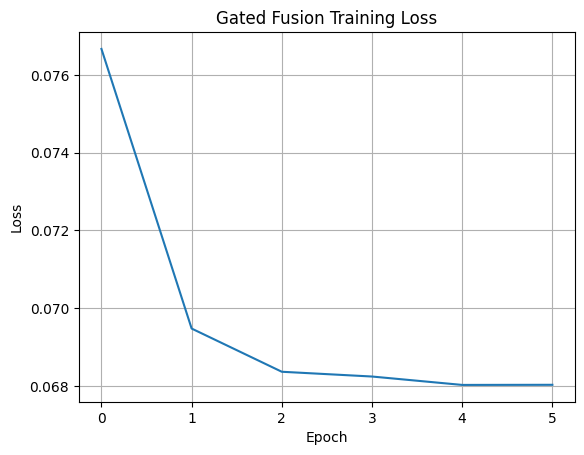

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Gated Fusion Training Loss")
plt.grid(True)
plt.show()

In [8]:
X_rays_test = np.load('../data/CNN_LSTM_test_rays.npy')  # (N, T, R)
Y_pos_test =  np.load('../data/CNN_LSTM_test_pos.npy')    # (N, T, 2)
print("X_rays_test shape:", X_rays_test.shape)
print("Y_pos_test shape:", Y_pos_test.shape)

Y_pos_final_test = Y_pos_test[:, -1, :]  # position at last time step
print("Y_pos_final_test shape:", Y_pos_final_test.shape)

X_rays_test shape: (4701, 5, 107)
Y_pos_test shape: (4701, 5, 2)
Y_pos_final_test shape: (4701, 2)


In [9]:
model.eval()
with torch.no_grad():
    i = np.random.randint(0, len(X_rays_test))
    test_ray = torch.tensor(X_rays_test[i], dtype=torch.float32)
    test_pos = torch.tensor(Y_pos_test[i], dtype=torch.float32)
    # print("Test ray shape:", Y_pos_test[i:i+1].shape)
    # prediction = model(test_ray, torch.zeros((1,5,2))).numpy()[0]
    prediction = model(test_ray).numpy()[0]

    print("Predicted (x, y, vx, vy):", prediction)
    print("Ground truth (x, y, vx, vy):", np.concatenate([Y_pos_final_test[i], Y_vel_test[i]]))


RuntimeError: Numpy is not available

In [5]:
class RayTransformer(nn.Module):
    def __init__(self, num_rays, d_model=64, nhead=4):
        super().__init__()
        self.input_proj = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Output x, z
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (B, R) → (B, R, 1)
        x = self.input_proj(x)  # (B, R, d_model)
        x = self.transformer(x)  # (B, R, d_model)
        x = x.mean(dim=1)  # Mean pool over rays
        return self.fc(x)

In [ ]:
# === Flatten dataset for frame-level training ===
# X_flat = X_rays.reshape(-1, X_rays.shape[2])           # (N*T, R)
# Y_flat = Y_pos.reshape(-1, Y_pos.shape[2]) # (N*T, 2)

X_tensor = torch.tensor(X_rays[:, -1, :], dtype=torch.float32)   # (N*T, R)
Y_tensor = torch.tensor(Y_pos_final, dtype=torch.float32)   # (N*T, 2)

ray_mean = X_tensor.mean()
ray_std = X_tensor.std()
X_tensor = (X_tensor - ray_mean) / ray_std

target_mean = Y_tensor.mean(0)
target_std = Y_tensor.std(0)
Y_norm = (Y_tensor - target_mean) / target_std

dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# === Build model ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RayTransformer(num_rays=107).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# === Train loop ===
losses = []
for epoch in range(25):
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch}: Loss = {avg_loss:.4f}")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\griff\anaconda3\envs\vision\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\griff\anaconda3\envs\vision\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\griff\anaconda3\envs\vision\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\griff\anaconda3\envs\vision\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start

Epoch 0: Loss = 0.1782
Epoch 1: Loss = 0.1697
Epoch 2: Loss = 0.1658
Epoch 3: Loss = 0.1651
Epoch 4: Loss = 0.1645
Epoch 5: Loss = 0.1642
Epoch 6: Loss = 0.1624
Epoch 7: Loss = 0.1621


KeyboardInterrupt: 

In [2]:
torch.cuda.is_available()

True